In [1]:
#!pip install scikit-optimize
#!pip install lightgbm
#!pip install tensorflow

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn import tree
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import lightgbm as lgb
import logging
from sklearn.svm import SVC
import time

In [3]:
file_path = 'SBA_tisztitott.csv'
df_sba=pd.read_csv(file_path, parse_dates=['ApprovalDate','DisbursementDate'])
df_sba.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,PaidBack
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,...,False,True,NaN,1999-02-28,60000.0,0.0,0.0,60000.0,48000.0,True
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,1997-02-28,1997,60,...,False,True,NaN,1997-05-31,40000.0,0.0,0.0,40000.0,32000.0,True
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,62,1997-02-28,1997,180,...,False,False,NaN,1997-12-31,287000.0,0.0,0.0,287000.0,215250.0,True
3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,...,False,True,NaN,1997-06-30,35000.0,0.0,0.0,35000.0,28000.0,True
4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,...,False,False,NaN,1997-05-14,229000.0,0.0,0.0,229000.0,229000.0,True


In [4]:
def describe_data(df):
    print(len(df_sba))
    column=[]
    d_type=[]
    uniques=[]
    n_uniques=[]
    nan=[]
    d_min=[]
    d_max=[]

    for i in df.columns:
        column.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        nan.append(df[i].isna().sum()/len(df)*100)
        if df[i].dtype != 'object':
            d_min.append(df[i].min())
        else:
            d_min.append(None)
        if df[i].dtype != 'object':
            d_max.append(df[i].max())
        else:
            d_max.append(None)

    return pd.DataFrame({'Column': column, 'type': d_type, 'unique sample': uniques, 'uniques': n_uniques, 'NaN%': nan, 'Min': d_min, 'Max': d_max})



In [5]:
describe_data(df_sba)

868076


,Column,type,unique sample,uniques,NaN%,Min,Max
0,Name,object,"[ABC HOBBYCRAFT, LANDMARK BAR & GRILLE (THE), ...",755201,0.000000,None,None
1,City,object,"[EVANSVILLE, NEW PARIS, BLOOMINGTON, BROKEN AR...",32035,0.000000,None,None
2,State,object,"[IN, OK, FL, CT, NJ]",51,0.000000,None,None
3,Zip,int64,"[47711, 46526, 47401, 74012, 32801]",33392,0.000000,0,99999
4,Bank,object,"[FIFTH THIRD BANK, 1ST SOURCE BANK, GRANT COUN...",5784,0.000000,None,None
5,BankState,object,"[OH, IN, OK, FL, DE]",56,0.000000,None,None
6,NAICS,int64,"[45, 72, 62, 0, 33]",25,0.000000,0,92
7,ApprovalDate,datetime64[ns],"[1997-02-28T00:00:00.000000000, 1980-06-02T00:...",9781,0.000000,1969-04-28 00:00:00,2014-06-25 00:00:00
8,ApprovalFY,int64,"[1997, 1980, 2006, 1998, 1999]",46,0.000000,1969,2014
9,Term,int64,"[84, 60, 180, 240, 120]",410,0.000000,0,569


In [6]:
df_sba = df_sba.drop(columns=['ChgOffDate'])

In [7]:
df_sba['DisbursementGross'] = df_sba['DisbursementGross'].astype('int64')
df_sba['BalanceGross'] = df_sba['BalanceGross'].astype('int64')
df_sba['ChgOffPrinGr'] = df_sba['ChgOffPrinGr'].astype('int64')
df_sba['GrAppv'] = df_sba['GrAppv'].astype('int64')
df_sba['SBA_Appv'] = df_sba['SBA_Appv'].astype('int64')
df_sba['PaidBack'] = df_sba['PaidBack'].astype(int)

In [8]:
#nem relevánsak
df_sba = df_sba.drop(columns=['City','Zip','Name','Bank','BankState','ApprovalDate','ApprovalFY','DisbursementDate'],axis=1)

In [9]:
#nem ismerhetjük hitelkérelem elbírálása során
df_sba = df_sba.drop(columns=['BalanceGross','ChgOffPrinGr','GrAppv'],axis=1)

In [10]:
len(df_sba[df_sba.NAICS==0])

197201

In [11]:
df_sba=df_sba[df_sba.NAICS!=0]

In [12]:
len(df_sba[df_sba.UrbanRural==0])

140245

In [13]:
df_sba=df_sba[df_sba.UrbanRural!=0]

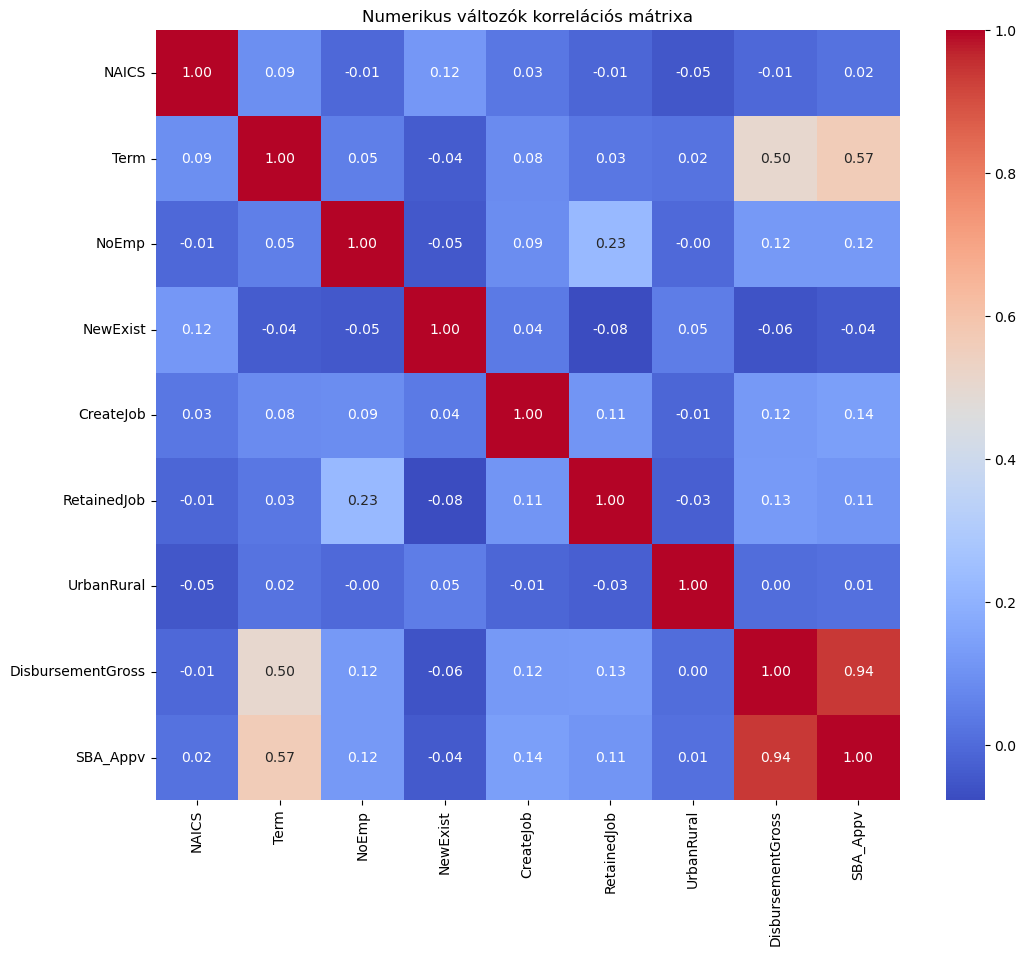

In [14]:
numeric_columns = df_sba.select_dtypes(include=['int64']).columns
correlation_matrix = df_sba[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerikus változók korrelációs mátrixa')
plt.show()

In [15]:
correlation_data = []
continuous_variables = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'SBA_Appv']
binary_variables=['UrbanRural','NewExist','RevLineCr','LowDoc','PaidBack']
for binary_variable in binary_variables:
    print(f"{binary_variable}")
    for continuous_variable in continuous_variables:
        correlation_coefficient, p_value = pointbiserialr(df_sba[binary_variable], df_sba[continuous_variable])
        print(f"\t{continuous_variable}: {correlation_coefficient:.2f}, p érték: {p_value:.2f}")
        correlation_data.append({'Binary Variable': binary_variable, 'Continuous Variable': continuous_variable, 'Correlation Coefficient': correlation_coefficient})

UrbanRural
	Term: 0.02, p érték: 0.00
	NoEmp: -0.00, p érték: 0.09
	CreateJob: -0.01, p érték: 0.00
	RetainedJob: -0.03, p érték: 0.00
	DisbursementGross: 0.00, p érték: 0.00
	SBA_Appv: 0.01, p érték: 0.00
NewExist
	Term: -0.04, p érték: 0.00
	NoEmp: -0.05, p érték: 0.00
	CreateJob: 0.04, p érték: 0.00
	RetainedJob: -0.08, p érték: 0.00
	DisbursementGross: -0.06, p érték: 0.00
	SBA_Appv: -0.04, p érték: 0.00
RevLineCr
	Term: -0.35, p érték: 0.00
	NoEmp: -0.04, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: 0.00, p érték: 0.35
	DisbursementGross: -0.21, p érték: 0.00
	SBA_Appv: -0.31, p érték: 0.00
LowDoc
	Term: -0.03, p érték: 0.00
	NoEmp: -0.01, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: -0.07, p érték: 0.00
	DisbursementGross: -0.10, p érték: 0.00
	SBA_Appv: -0.07, p érték: 0.00
PaidBack
	Term: 0.34, p érték: 0.00
	NoEmp: 0.03, p érték: 0.00
	CreateJob: 0.02, p érték: 0.00
	RetainedJob: 0.02, p érték: 0.00
	DisbursementGross: 0.13, p érték: 0.00
	SBA_A

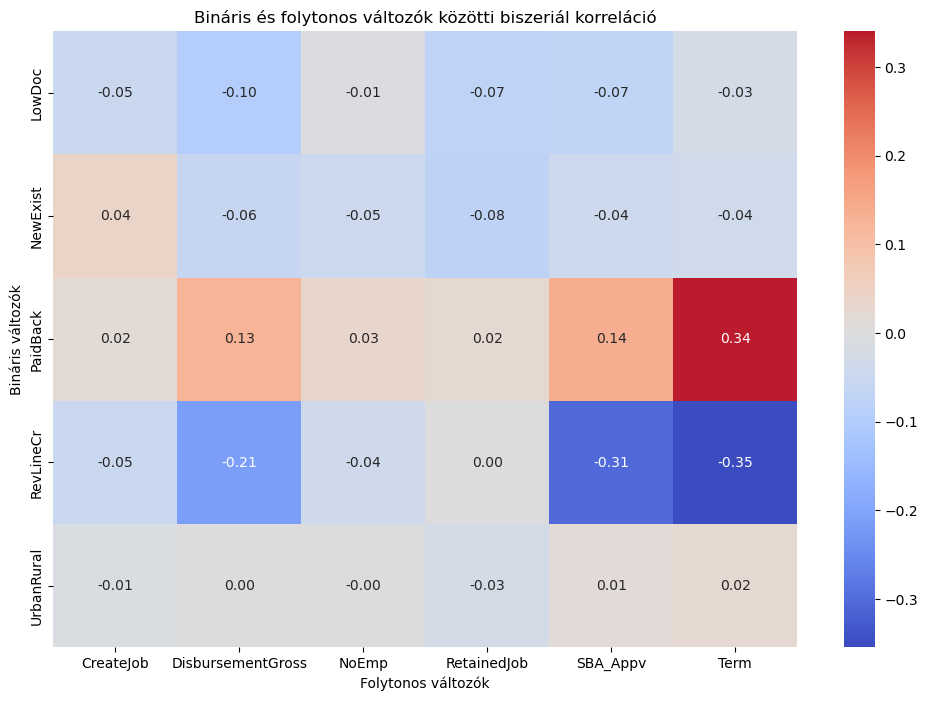

In [16]:
correlation_df = pd.DataFrame(correlation_data)
plt.figure(figsize=(12, 8))
correlation_matrix = correlation_df.pivot(index="Binary Variable", columns="Continuous Variable", values="Correlation Coefficient")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Bináris és folytonos változók közötti biszeriál korreláció")
plt.xlabel('Folytonos változók')
plt.ylabel('Bináris változók')
plt.show()

In [17]:
describe_data(df_sba)

530630


,Column,type,unique sample,uniques,NaN%,Min,Max
0,State,object,"[NC, AR, CA, FL, LA]",51,0.0,None,None
1,NAICS,int64,"[44, 72, 61, 23, 53]",24,0.0,11,92
2,Term,int64,"[162, 126, 83, 84, 60]",337,0.0,0,569
3,NoEmp,int64,"[2, 7, 18, 4, 3]",406,0.0,0,8000
4,NewExist,int64,"[2, 1]",2,0.0,1,2
5,CreateJob,int64,"[0, 5, 4, 1, 20]",204,0.0,0,5085
6,RetainedJob,int64,"[0, 23, 4, 6, 1]",310,0.0,0,9500
7,UrbanRural,int64,"[1, 2]",2,0.0,1,2
8,RevLineCr,bool,"[False, True]",2,0.0,False,True
9,LowDoc,bool,"[False, True]",2,0.0,False,True


In [18]:
df_sba.to_csv('data_for_learning.csv', index=False)

In [19]:
def makeplot(variable1, variable2, variable3):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=variable1, y=variable2, hue=variable3)
    plt.title('Scatter plot by Paidback groups')
    plt.legend(title='Paidback')
    plt.grid(True)
    plt.show()

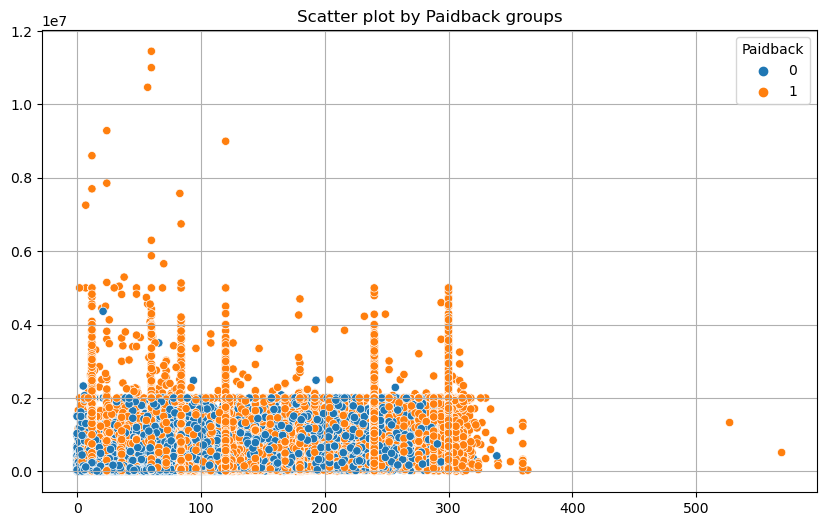

In [20]:
makeplot(df_sba['Term'].values, df_sba['DisbursementGross'].values , df_sba['PaidBack'].values)

### Standardizálás

In [21]:
numeric_feature_names = ['Term', 'NoEmp', 'CreateJob','RetainedJob','DisbursementGross','SBA_Appv']
categoricial_feature_names = ['State','NAICS', 'NewExist','UrbanRural']

df_standardized = df_sba.copy()

ss = StandardScaler()
ss.fit(df_standardized[numeric_feature_names])
df_standardized[numeric_feature_names] = ss.transform(df_standardized[numeric_feature_names])
df_standardized = pd.get_dummies(df_standardized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_standardized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)

df_standardized

['State_NH', 'NAICS_92', 'LowDoc', 'State_SC', 'NAICS_11', 'UrbanRural_1', 'NAICS_45', 'State_KY', 'NAICS_48', 'State_MD', 'State_FL', 'State_RI', 'State_OK', 'UrbanRural_2', 'State_CA', 'State_MN', 'State_UT', 'NAICS_53', 'State_TX', 'PaidBack', 'RevLineCr', 'State_AL', 'State_WV', 'State_OH', 'State_MA', 'State_PA', 'State_DE', 'State_CT', 'State_CO', 'NAICS_52', 'State_LA', 'NAICS_49', 'State_ME', 'State_NC', 'NAICS_32', 'NAICS_56', 'State_WI', 'State_VT', 'State_MO', 'NAICS_51', 'State_IN', 'NAICS_81', 'NAICS_22', 'NAICS_33', 'NAICS_61', 'NAICS_54', 'State_ID', 'NewExist_2', 'State_IA', 'State_NM', 'State_NY', 'State_ND', 'State_WA', 'State_NV', 'NAICS_42', 'NAICS_72', 'State_SD', 'State_MS', 'State_GA', 'State_TN', 'State_KS', 'NAICS_55', 'NewExist_1', 'State_NE', 'State_AR', 'State_WY', 'State_MT', 'State_MI', 'NAICS_44', 'NAICS_71', 'State_DC', 'State_HI', 'State_IL', 'NAICS_62', 'State_VA', 'State_OR', 'State_AZ', 'NAICS_23', 'NAICS_21', 'State_NJ', 'NAICS_31', 'State_AK']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,0.936903,-0.150286,-0.180372,-0.266334,False,False,0.193103,0.216879,1,0,...,0,0,0,0,0,0,0,1,1,0
24,0.424974,-0.039197,-0.180372,-0.266334,False,False,-0.179962,-0.075437,1,0,...,0,0,0,1,0,0,1,0,1,0
28,-0.186496,0.205201,0.195437,0.756516,True,False,0.788018,-0.341291,1,0,...,1,0,0,0,0,0,0,1,1,0
30,-0.172276,-0.105850,-0.180372,-0.088447,True,False,-0.455856,-0.470820,1,0,...,0,0,0,0,0,0,1,0,1,0
32,-0.513562,-0.128068,-0.180372,-0.266334,False,False,-0.460484,-0.371182,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,2.046082,0.249637,0.947053,-0.266334,False,False,1.014425,1.488056,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,-0.172276,-0.128068,-0.180372,-0.132919,True,False,-0.570909,-0.520638,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,2.046082,0.027457,-0.180372,-0.221862,False,False,2.714265,3.596389,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,0.154789,-0.150286,-0.180372,-0.266334,False,False,-0.074887,-0.032414,0,0,...,0,0,0,0,0,0,1,0,0,1


### Normalizálás

In [22]:
df_normalized= df_sba.copy()
normalizer = MinMaxScaler()

df_normalized[numeric_feature_names] = normalizer.fit_transform(df_normalized[numeric_feature_names])
df_normalized = pd.get_dummies(df_normalized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_normalized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_normalized

['State_NH', 'NAICS_92', 'LowDoc', 'State_SC', 'NAICS_11', 'UrbanRural_1', 'NAICS_45', 'State_KY', 'NAICS_48', 'State_MD', 'State_FL', 'State_RI', 'State_OK', 'UrbanRural_2', 'State_CA', 'State_MN', 'State_UT', 'NAICS_53', 'State_TX', 'PaidBack', 'RevLineCr', 'State_AL', 'State_WV', 'State_OH', 'State_MA', 'State_PA', 'State_DE', 'State_CT', 'State_CO', 'NAICS_52', 'State_LA', 'NAICS_49', 'State_ME', 'State_NC', 'NAICS_32', 'NAICS_56', 'State_WI', 'State_VT', 'State_MO', 'NAICS_51', 'State_IN', 'NAICS_81', 'NAICS_22', 'NAICS_33', 'NAICS_61', 'NAICS_54', 'State_ID', 'NewExist_2', 'State_IA', 'State_NM', 'State_NY', 'State_ND', 'State_WA', 'State_NV', 'NAICS_42', 'NAICS_72', 'State_SD', 'State_MS', 'State_GA', 'State_TN', 'State_KS', 'NAICS_55', 'NewExist_1', 'State_NE', 'State_AR', 'State_WY', 'State_MT', 'State_MI', 'NAICS_44', 'NAICS_71', 'State_DC', 'State_HI', 'State_IL', 'NAICS_62', 'State_VA', 'State_OR', 'State_AZ', 'NAICS_23', 'NAICS_21', 'State_NJ', 'NAICS_31', 'State_AK']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,0.284710,0.000250,0.000000,0.000000,False,False,0.021796,0.042127,1,0,...,0,0,0,0,0,0,0,1,1,0
24,0.221441,0.000875,0.000000,0.000000,False,False,0.011650,0.025826,1,0,...,0,0,0,1,0,0,1,0,1,0
28,0.145870,0.002250,0.000983,0.002421,True,False,0.037977,0.011001,1,0,...,1,0,0,0,0,0,0,1,1,0
30,0.147627,0.000500,0.000000,0.000421,True,False,0.004146,0.003778,1,0,...,0,0,0,0,0,0,1,0,1,0
32,0.105448,0.000375,0.000000,0.000000,False,False,0.004020,0.009334,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,0.421793,0.002500,0.002950,0.000000,False,False,0.044134,0.113013,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,0.147627,0.000375,0.000000,0.000316,True,False,0.001017,0.001000,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,0.421793,0.001250,0.000000,0.000105,False,False,0.090366,0.230581,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,0.188049,0.000250,0.000000,0.000000,False,False,0.014508,0.028225,0,0,...,0,0,0,0,0,0,1,0,0,1


### Skálázatlan adatok átalakítása

In [23]:
df_sba_dummies = pd.get_dummies(df_sba, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_sba_dummies.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_sba_dummies

['State_NH', 'NAICS_92', 'LowDoc', 'State_SC', 'NAICS_11', 'UrbanRural_1', 'NAICS_45', 'State_KY', 'NAICS_48', 'State_MD', 'State_FL', 'State_RI', 'State_OK', 'UrbanRural_2', 'State_CA', 'State_MN', 'State_UT', 'NAICS_53', 'State_TX', 'PaidBack', 'RevLineCr', 'State_AL', 'State_WV', 'State_OH', 'State_MA', 'State_PA', 'State_DE', 'State_CT', 'State_CO', 'NAICS_52', 'State_LA', 'NAICS_49', 'State_ME', 'State_NC', 'NAICS_32', 'NAICS_56', 'State_WI', 'State_VT', 'State_MO', 'NAICS_51', 'State_IN', 'NAICS_81', 'NAICS_22', 'NAICS_33', 'NAICS_61', 'NAICS_54', 'State_ID', 'NewExist_2', 'State_IA', 'State_NM', 'State_NY', 'State_ND', 'State_WA', 'State_NV', 'NAICS_42', 'NAICS_72', 'State_SD', 'State_MS', 'State_GA', 'State_TN', 'State_KS', 'NAICS_55', 'NewExist_1', 'State_NE', 'State_AR', 'State_WY', 'State_MT', 'State_MI', 'NAICS_44', 'NAICS_71', 'State_DC', 'State_HI', 'State_IL', 'NAICS_62', 'State_VA', 'State_OR', 'State_AZ', 'NAICS_23', 'NAICS_21', 'State_NJ', 'NAICS_31', 'State_AK']


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,SBA_Appv,PaidBack,State_AK,...,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,NewExist_1,NewExist_2,UrbanRural_1,UrbanRural_2
12,162,2,0,0,False,False,253400,190050,1,0,...,0,0,0,0,0,0,0,1,1,0
24,126,7,0,0,False,False,137300,116705,1,0,...,0,0,0,1,0,0,1,0,1,0
28,83,18,5,23,True,False,438541,50000,1,0,...,1,0,0,0,0,0,0,1,1,0
30,84,4,0,4,True,False,51440,17500,1,0,...,0,0,0,0,0,0,1,0,1,0
32,60,3,0,0,False,False,50000,42500,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863829,240,20,15,0,False,False,509000,509000,1,0,...,0,0,0,0,0,0,1,0,1,0
863834,84,3,0,3,True,False,15635,5000,1,0,...,0,0,0,0,0,0,1,0,1,0
863852,240,10,0,1,False,False,1038000,1038000,1,0,...,0,0,0,1,0,0,1,0,1,0
865073,107,2,0,0,False,False,170000,127500,0,0,...,0,0,0,0,0,0,1,0,0,1


### Standardizált adatok szétválasztása tanító és teszt adathalmazra

In [24]:
X_s = df_standardized.drop(columns=['PaidBack'])
y_s = df_standardized['PaidBack']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_s.shape)
print("Teszt adatok mérete (X):", X_test_s.shape)
print("Tanító adatok mérete (y):", y_train_s.shape)
print("Teszt adatok mérete (y):", y_test_s.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


### Normalizált adatok szétválasztása tanító és teszt adathalmazra

In [25]:
X_n = df_normalized.drop(columns=['PaidBack'])
y_n = df_normalized['PaidBack']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_n.shape)
print("Teszt adatok mérete (X):", X_test_n.shape)
print("Tanító adatok mérete (y):", y_train_n.shape)
print("Teszt adatok mérete (y):", y_test_n.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


### Skálázatlan adatok szétválasztása tanító és teszt adatokra

In [26]:
X_e = df_sba_dummies.drop(columns=['PaidBack'])
y_e = df_sba_dummies['PaidBack']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_e.shape)
print("Teszt adatok mérete (X):", X_test_e.shape)
print("Tanító adatok mérete (y):", y_train_e.shape)
print("Teszt adatok mérete (y):", y_test_e.shape)

Tanító adatok mérete (X): (424504, 87)
Teszt adatok mérete (X): (106126, 87)
Tanító adatok mérete (y): (424504,)
Teszt adatok mérete (y): (106126,)


## Logisztikus regresszor modell

In [27]:
start_time = time.time()

lr_s = LogisticRegression(max_iter=1000)
model_s = lr_s.fit(X_train_s, y_train_s)
lr_n = LogisticRegression(max_iter=1000)
model_n = lr_n.fit(X_train_n, y_train_n)
lr_e = LogisticRegression(max_iter=1000)
model_e = lr_e.fit(X_train_e, y_train_e)

end_time = time.time()
training_time = end_time - start_time
print(f"A tanítási idő: {training_time:.2f} másodperc")

A tanítási idő: 35.59 másodperc


Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.39      0.01      0.02     24677
           1       0.77      0.99      0.87     81449

    accuracy                           0.77    106126
   macro avg       0.58      0.50      0.44    106126
weighted avg       0.68      0.77      0.67    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.69      0.40      0.50     24677
           1       0.84      0.95      0.89     81449

    accuracy                           0.82    106126
   macro avg       0.76      0.67      0.70    106126
weighted avg       0.80      0.82      0.80    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.69      0.39      0.49     24677
           1       0.84      0.95      0.89     81449

    accuracy                           0.82    106126
   macro avg       0.76      0.67      0.69    106126
weighted avg   

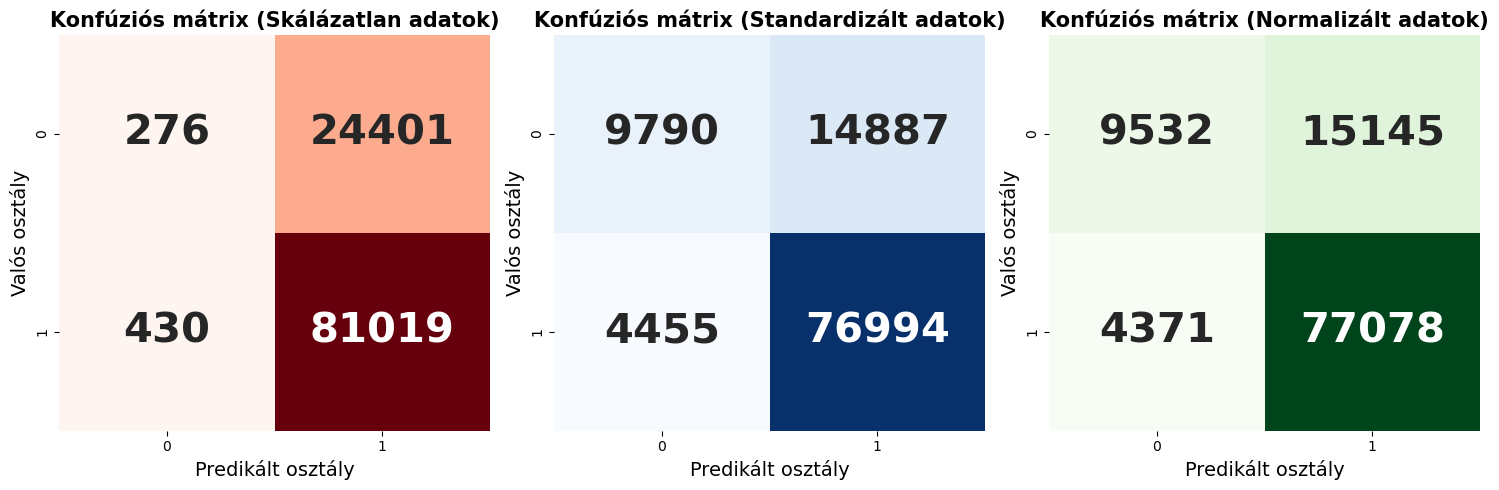

In [28]:
y_pred_s = lr_s.predict(X_test_s)
y_pred_n = lr_n.predict(X_test_n)
y_pred_e = lr_e.predict(X_test_e)
cm_s_lr = confusion_matrix(y_test_s, y_pred_s)
cm_n_lr = confusion_matrix(y_test_n, y_pred_n)
cm_e_lr = confusion_matrix(y_test_e, y_pred_e)
accuracy_s_lr = accuracy_score(y_test_s, y_pred_s)
accuracy_n_lr = accuracy_score(y_test_n, y_pred_n)
accuracy_e_lr = accuracy_score(y_test_e, y_pred_e)
precision_s_lr = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_lr = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_lr = precision_score(y_test_e, y_pred_e, average='weighted')
recall_s_lr = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_lr = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_lr = recall_score(y_test_e, y_pred_e, average='weighted')
f1_s_lr = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_lr = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_lr = f1_score(y_test_e, y_pred_e, average='weighted')
mse_s_lr = mean_squared_error(y_test_s, y_pred_s)
mse_n_lr = mean_squared_error(y_test_n, y_pred_n)
mse_e_lr = mean_squared_error(y_test_e, y_pred_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print('Normalizált adatok')
print(classification_report(y_test_n, y_pred_n))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_lr, precision_e_lr, recall_e_lr, f1_e_lr, mse_e_lr],
    "Standardizált adatok": [accuracy_s_lr, precision_s_lr, recall_s_lr, f1_s_lr, mse_s_lr],
    "Normalized adatok": [accuracy_n_lr, precision_n_lr, recall_n_lr, f1_n_lr, mse_n_lr]   
}
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_lr, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_lr, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_lr, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Döntési fa modell

In [29]:
start_time = time.time()

decision_tree_s = DecisionTreeClassifier()
decision_tree_s.fit(X_train_s, y_train_s)
y_pred_s = decision_tree_s.predict(X_test_s)

decision_tree_n = DecisionTreeClassifier()
decision_tree_n.fit(X_train_n, y_train_n)
y_pred_n = decision_tree_n.predict(X_test_n)

decision_tree_e = DecisionTreeClassifier()
decision_tree_e.fit(X_train_e, y_train_e)
y_pred_e = decision_tree_e.predict(X_test_e)

end_time = time.time()
training_time = end_time - start_time
print(f"A tanítási idő: {training_time:.2f} másodperc\n")

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n))

accuracy_s_df = accuracy_score(y_test_s, y_pred_s)
accuracy_n_df = accuracy_score(y_test_n, y_pred_n)
accuracy_e_df = accuracy_score(y_test_e, y_pred_e)

precision_s_df = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_df = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_df = precision_score(y_test_e, y_pred_e, average='weighted')

recall_s_df = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_df = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_df = recall_score(y_test_e, y_pred_e, average='weighted')

f1_s_df = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_df = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_df = f1_score(y_test_e, y_pred_e, average='weighted')

mse_s_df = mean_squared_error(y_test_s, y_pred_s)
mse_n_df = mean_squared_error(y_test_n, y_pred_n)
mse_e_df = mean_squared_error(y_test_e, y_pred_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_df, precision_e_df, recall_e_df, f1_e_df, mse_e_df],
    "Standardizált adatok": [accuracy_s_df, precision_s_df, recall_s_df, f1_s_df, mse_s_df],
    "Normalizált adatok": [accuracy_n_df, precision_n_df, recall_n_df, f1_n_df, mse_n_df]   
}

results_df = pd.DataFrame(results)
print(results_df)

A tanítási idő: 38.37 másodperc

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87      0.87    106126
weighted avg       0.91      0.91      0.91    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87      0.87    106126
weighted avg       0.91      0.91      0.91    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     24677
           1       0.94      0.94      0.94     81449

    accuracy                           0.91    106126
   macro avg       0.87      0.87   

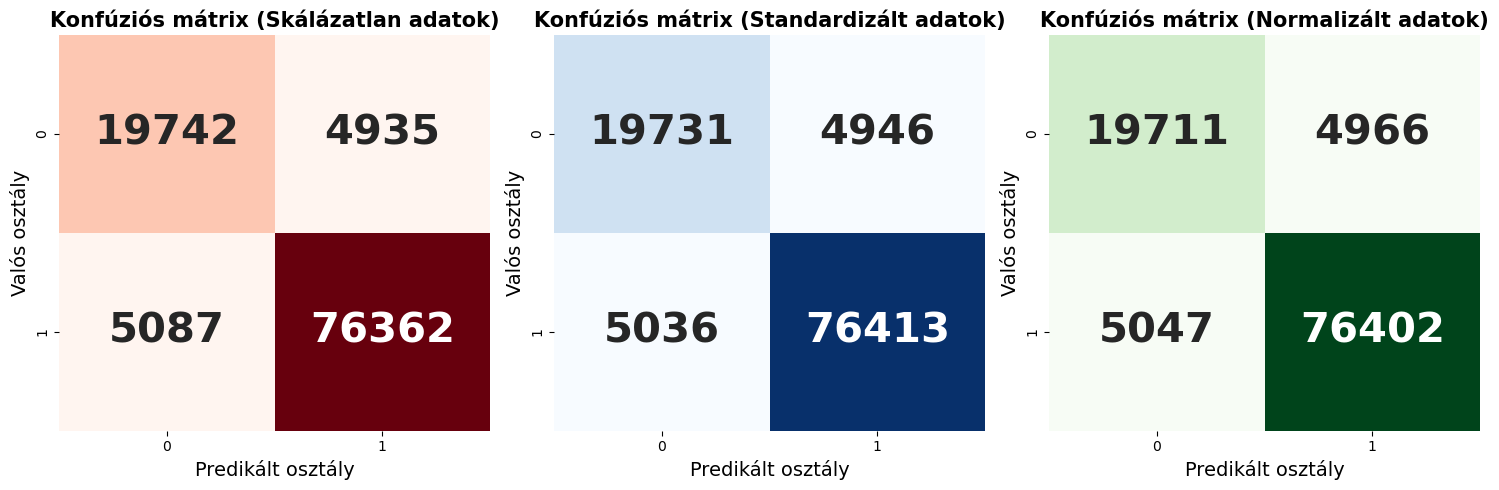

In [30]:
cm_s_df = confusion_matrix(y_test_s, y_pred_s)
cm_n_df = confusion_matrix(y_test_n, y_pred_n)
cm_e_df = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_df, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_df, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_df, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Regularizált döntési fa

In [31]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
#    'min_samples_split': [2, 5, 10, 15, 20],
#    'min_samples_leaf': [1, 2, 5, 10, 15],
#    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0]
}

grid_search_s = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_n = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_e = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

start_time = time.time()

grid_search_s.fit(X_train_s, y_train_s)
grid_search_n.fit(X_train_n, y_train_n)
grid_search_e.fit(X_train_e, y_train_e)

best_params_e = grid_search_e.best_params_
print("Legjobb paraméterek Eredeti adatokon:", best_params_e)
best_params_s = grid_search_s.best_params_
print("Legjobb paraméterek Standardizált adatokon:", best_params_s)
best_params_n = grid_search_n.best_params_
print("Legjobb paraméterek Normalizált adatokon:", best_params_n)

best_model_e = grid_search_e.best_estimator_
y_pred_e = best_model_e.predict(X_test_e)
best_model_s = grid_search_s.best_estimator_
y_pred_s = best_model_s.predict(X_test_s)
best_model_n = grid_search_n.best_estimator_
y_pred_n = best_model_n.predict(X_test_n)

end_time = time.time()
training_time = end_time - start_time
print(f"\nA tanítási idő: {training_time:.2f} másodperc\n")

print("Eredeti adatokon a legjobb modell értékelése:")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_s, y_pred_s))
print("Normalizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_n, y_pred_n))
accuracy_e_rdf = accuracy_score(y_test_e, y_pred_e)
accuracy_s_rdf = accuracy_score(y_test_s, y_pred_s)
accuracy_n_rdf = accuracy_score(y_test_n, y_pred_n)

precision_s_rdf = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_rdf = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_rdf = precision_score(y_test_e, y_pred_e, average='weighted')

recall_s_rdf = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_rdf = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_rdf = recall_score(y_test_e, y_pred_e, average='weighted')

f1_s_rdf = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_rdf = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_rdf = f1_score(y_test_e, y_pred_e, average='weighted')

mse_s_rdf = mean_squared_error(y_test_s, y_pred_s)
mse_n_rdf = mean_squared_error(y_test_n, y_pred_n)
mse_e_rdf = mean_squared_error(y_test_e, y_pred_e)

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_rdf, precision_e_rdf, recall_e_rdf, f1_e_rdf, mse_e_rdf],
    "Standardizált adatok": [accuracy_s_rdf, precision_s_rdf, recall_s_rdf, f1_s_rdf, mse_s_rdf],
    "Normalizált adatok": [accuracy_n_rdf, precision_n_rdf, recall_n_rdf, f1_n_rdf, mse_n_rdf]   
}
results_df = pd.DataFrame(results)
print(results_df)

Legjobb paraméterek Eredeti adatokon: {'max_depth': 15}
Legjobb paraméterek Standardizált adatokon: {'max_depth': 15}
Legjobb paraméterek Normalizált adatokon: {'max_depth': 15}

A tanítási idő: 670.29 másodperc

Eredeti adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     24677
           1       0.96      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.90      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Standardizált adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     24677
           1       0.96      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.90      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Normalizált adatokon a legjobb mode

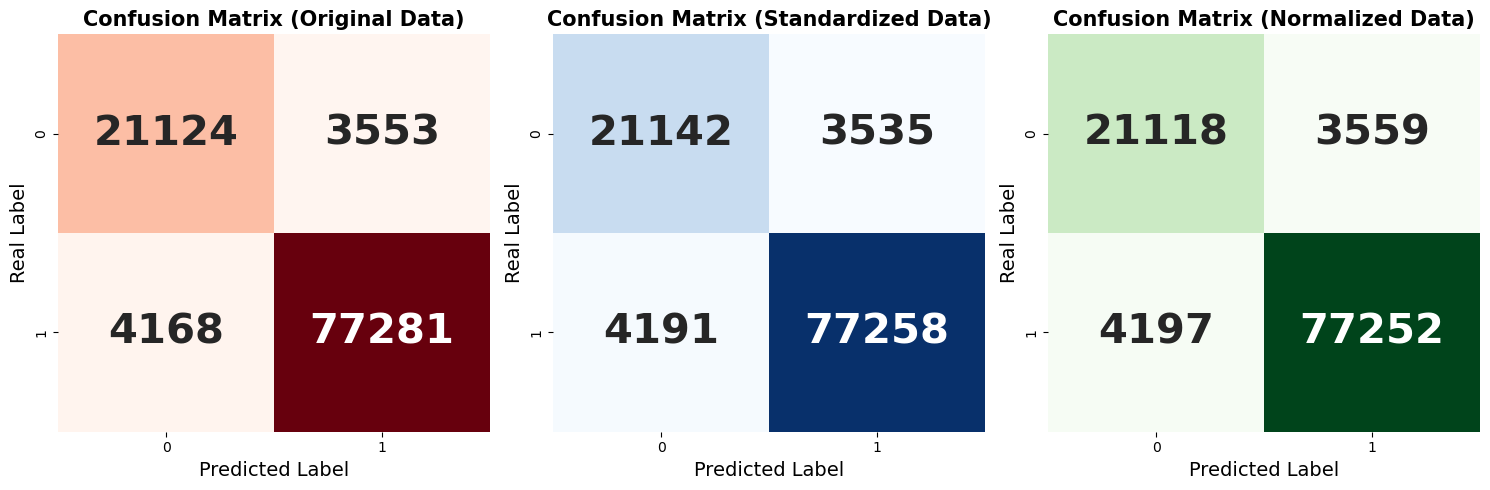

In [32]:
cm_s_rdf = confusion_matrix(y_test_s, y_pred_s)
cm_n_rdf = confusion_matrix(y_test_n, y_pred_n)
cm_e_rdf = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_rdf, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Confusion Matrix (Original Data)',fontsize=15, fontweight='bold')
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('Real Label',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_rdf, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Confusion Matrix (Standardized Data)',fontsize=15, fontweight='bold')
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('Real Label',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_rdf, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Confusion Matrix (Normalized Data)',fontsize=15, fontweight='bold')
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('Real Label',fontsize=14)

plt.tight_layout()
plt.show()

#### Regularizálás BayesSearchCV használatával

In [33]:
param_space = {
    'max_depth': Categorical([None] + list(range(1, 31, 5))),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'ccp_alpha': Real(0.0, 0.1)
}

opt = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

start_time = time.time()

#Standardizált
opt.fit(X_train_s, y_train_s)

best_params = opt.best_params_
print("Legjobb paraméterek Standardizált adatokon:", best_params)
best_model = opt.best_estimator_
y_pred_s = best_model.predict(X_test_s)
print("Standardizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_s, y_pred_s))
accuracy_s_rdf = accuracy_score(y_test_s, y_pred_s)
precision_s_rdf = precision_score(y_test_s, y_pred_s, average='weighted')
recall_s_rdf = recall_score(y_test_s, y_pred_s, average='weighted')
f1_s_rdf = f1_score(y_test_s, y_pred_s, average='weighted')
mse_s_rdf = mean_squared_error(y_test_s, y_pred_s)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])


#Normalizált
opt.fit(X_train_n, y_train_n)

best_params = opt.best_params_
print("Legjobb paraméterek Normalizált adatokon:", best_params)
best_model = opt.best_estimator_
y_pred_n = best_model.predict(X_test_n)
print("Normalizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_n, y_pred_n))
accuracy_n_rdf = accuracy_score(y_test_n, y_pred_n)
precision_n_rdf = precision_score(y_test_n, y_pred_n, average='weighted')
recall_n_rdf = recall_score(y_test_n, y_pred_n, average='weighted')
f1_n_rdf = f1_score(y_test_n, y_pred_n, average='weighted')
mse_n_rdf = mean_squared_error(y_test_n, y_pred_n)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Normalizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

#Eredeti
opt.fit(X_train_e, y_train_e)

best_params = opt.best_params_
print("Legjobb paraméterek Skálázatlan adatokon:", best_params)
best_model = opt.best_estimator_
y_pred_e = best_model.predict(X_test_e)
print("Skálázatlan adatokon a legjobb modell értékelése:")
print(classification_report(y_test_e, y_pred_e))
accuracy_e_rdf = accuracy_score(y_test_e, y_pred_e)
precision_e_rdf = precision_score(y_test_e, y_pred_e, average='weighted')
recall_e_rdf = recall_score(y_test_e, y_pred_e, average='weighted')
f1_e_rdf = f1_score(y_test_e, y_pred_e, average='weighted')
mse_e_rdf = mean_squared_error(y_test_e, y_pred_e)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Skálázatlan adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

end_time = time.time()
training_time = end_time - start_time
print(f"A tanítási idő: {training_time:.2f} másodperc")

Legjobb paraméterek Standardizált adatokon: OrderedDict([('ccp_alpha', 0.0), ('max_depth', 16), ('min_samples_leaf', 10), ('min_samples_split', 10)])
Standardizált adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     24677
           1       0.96      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.91      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:
                                                                                                    params  \
37                    {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 10}   
39                     {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 2}   
28   {'ccp_alpha': 2.1063127884746187e-05, 'max_depth': 11, 'min_samp

Legjobb paraméterek Normalizált adatokon: OrderedDict([('ccp_alpha', 0.0), ('max_depth', 16), ('min_samples_leaf', 10), ('min_samples_split', 10)])
Normalizált adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     24677
           1       0.96      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.91      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Paraméterkombinációk és rangsorolásuk táblázata Normalizált adatokon:
                                                                                                   params  \
23                   {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 10}   
16                    {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 9}   
27   {'ccp_alpha': 2.001529602545516e-05, 'max_depth': 11, 'min_samples_leaf':

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     24677
           1       0.95      0.95      0.95     81449

    accuracy                           0.93    106126
   macro avg       0.90      0.90      0.90    106126
weighted avg       0.93      0.93      0.93    106126

Paraméterkombinációk és rangsorolásuk táblázata Skálázatlan adatokon:
                                                                                                   params  \
16                   {'ccp_alpha': 0.0, 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 10}   
32                    {'ccp_alpha': 0.0, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 10}   
11                    {'ccp_alpha': 0.0, 'max_depth': 21, 'min_samples_leaf': 10, 'min_samples_split': 9}   
27                    {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 10}   
12                 {'ccp_alpha': 0.0, 'max_depth': None, '

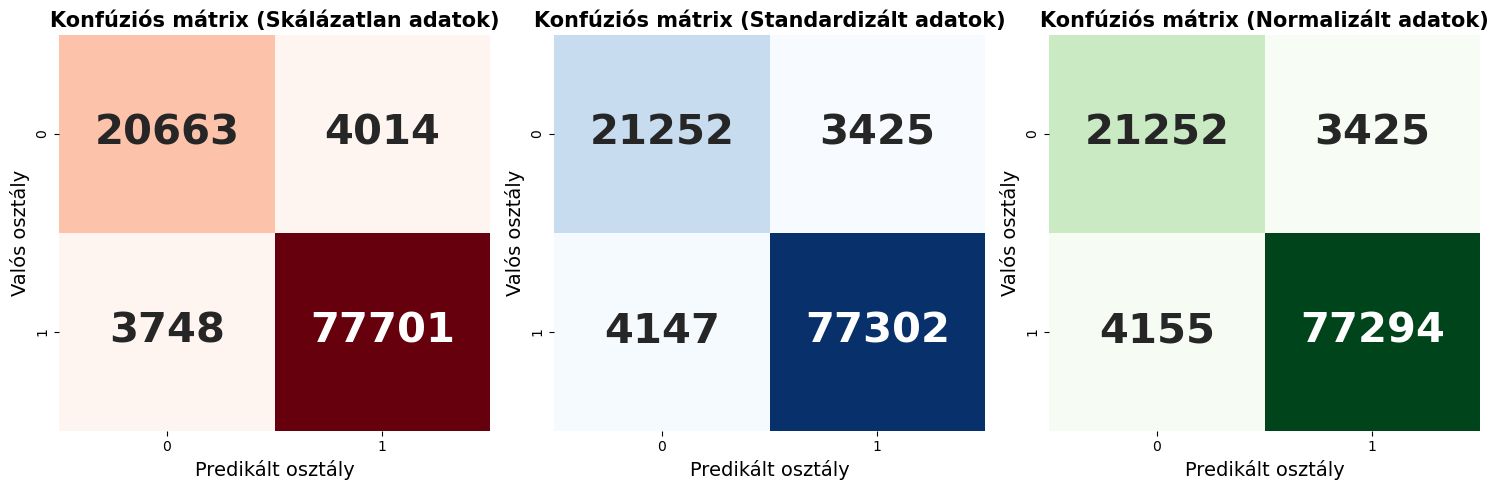

In [34]:
cm_s_rdf = confusion_matrix(y_test_s, y_pred_s)
cm_n_rdf = confusion_matrix(y_test_n, y_pred_n)
cm_e_rdf = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_rdf, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_rdf, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_rdf, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

In [35]:
results2 = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_rdf, precision_e_rdf, recall_e_rdf, f1_e_rdf, mse_e_rdf],
    "Standardizált adatok": [accuracy_s_rdf, precision_s_rdf, recall_s_rdf, f1_s_rdf, mse_s_rdf],
    "Normalizált adatok": [accuracy_n_rdf, precision_n_rdf, recall_n_rdf, f1_n_rdf, mse_n_rdf]   
}
results2_df = pd.DataFrame(results2)
print(results2_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.926861              0.928651            0.928575
1  Precision            0.926599              0.929473            0.929409
2     Recall            0.926861              0.928651            0.928575
3   F1 Score            0.926722              0.929006            0.928935
4        MSE            0.073139              0.071349            0.071425


In [36]:
def tree_graph_to_png(dtree, feature_names, figs, fonts):
    plt.figure(figsize=figs)
    tree.plot_tree(dtree, filled=True, rounded=True, feature_names = feature_names, fontsize=fonts)
    plt.show()

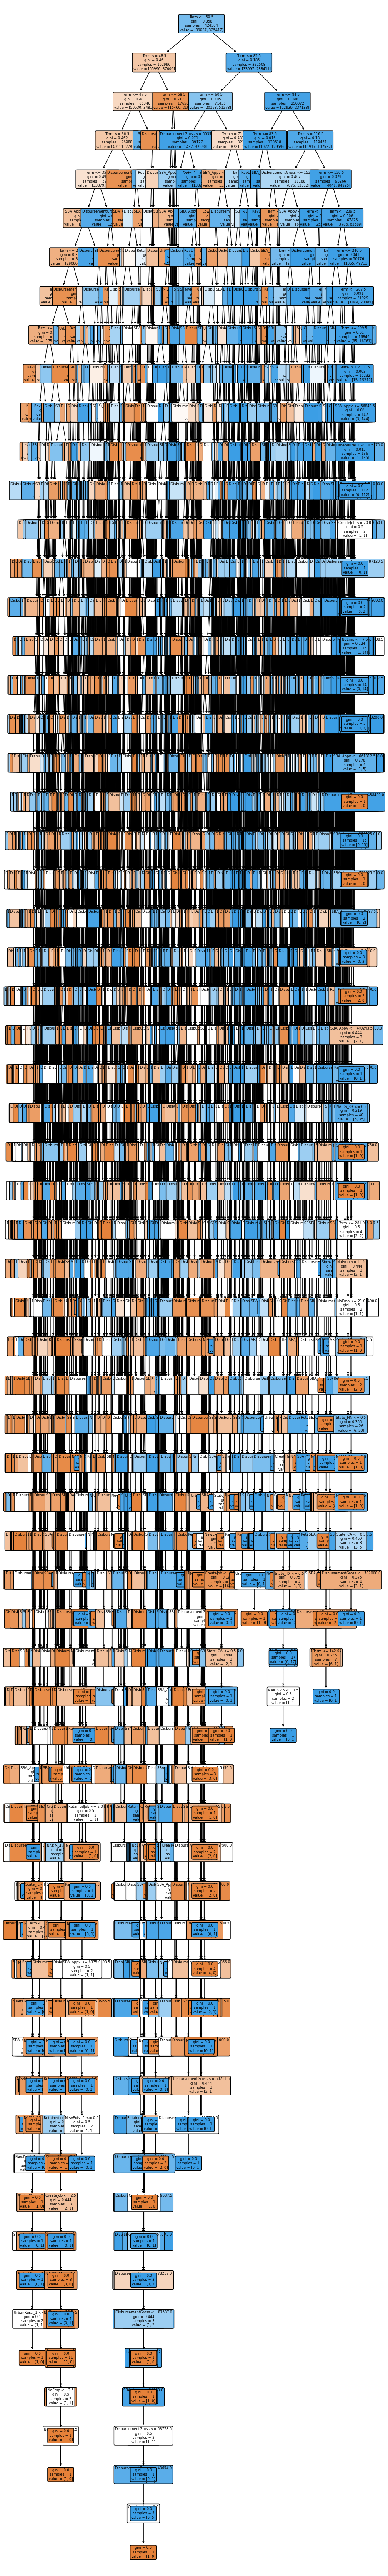

In [37]:
tree_graph_to_png(dtree=best_model, feature_names=list(X_train_e.columns), figs=(10, 80), fonts=6)

## Gradiens turbózás

In [27]:
params_s = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': [11,12],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #regularizálásból
    'min_samples_leaf': 10,          
    'ccp_alpha': 0.0,
    'min_samples_split': 10,
    'max_depth': 16,
}

params_n = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': [11,12],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #regularizálásból
    'min_samples_leaf': 10,          
    'ccp_alpha': 0.0,
    'min_samples_split': 10,
    'max_depth': 16,
}

params_e = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': [11,12],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #regularizálásból
    'min_samples_leaf': 10,          
    'ccp_alpha': 0.0,
    'min_samples_split': 10,
    'max_depth': 11,
}


In [28]:
def experiment(objective, label_type, x_train, x_test, y_train, y_test, i, params):
    lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
    lgb_test = lgb.Dataset(x_test, y_test, free_raw_data=False)
    
    params['objective'] = objective
    
    if i==0:
        gbm = lgb.train(
            params = params,
            train_set = lgb_train,
            valid_sets = [lgb_train, lgb_test],
            num_boost_round = 10
        ) 
        gbm.save_model(str(objective)+'gbmodel.txt')
    else:
        gbmprev = lgb.Booster(model_file=str(objective)+'gbmodel.txt') 
        gbm = lgb.train(
            params = params,
            train_set = lgb_train,
            valid_sets = [lgb_train, lgb_test],
            num_boost_round = 10,
            init_model = gbmprev
        ) 
        gbm.save_model(str(objective)+'gbmodel.txt') 
      
    y_fitted = pd.Series(gbm.predict(x_test, num_iteration = gbm.best_iteration))   
    y_pred = pd.DataFrame({'y_pred': y_fitted})
    y_true = pd.DataFrame({'y_true': y_test}).reset_index(drop=True)
    
    return pd.concat([y_true, y_pred], axis=1)

In [29]:
start_time = time.time()

primary_target = 'binary'
tree_num = 30
A_s = [experiment(primary_target, 'binary', X_train_s, X_test_s, y_train_s, y_test_s, k, params_s) for k in range(tree_num)]
A_n = [experiment(primary_target, 'binary', X_train_n, X_test_n, y_train_n, y_test_n, k, params_n) for k in range(tree_num)]
A_e = [experiment(primary_target, 'binary', X_train_e, X_test_e, y_train_e, y_test_e, k, params_e) for k in range(tree_num)]

end_time = time.time()
training_time = end_time - start_time
print(f"A tanítási idő: {training_time:.2f} másodperc")

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of negative: 99087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samp

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of n

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of n

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of n

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of n

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 325417, number of n

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1424
[LightGBM] [Info] Number of data points in the train set: 424504, number of used features: 87
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ig

[LightGBM] [Warning] Unknown parameter: ccp_alpha
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_samples_leaf=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
A tanítási idő: 256.37 másodperc


Skálázatlan adatok


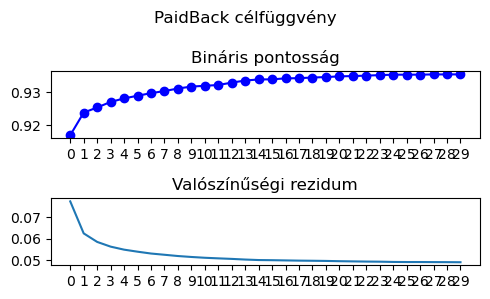

Standardizált adatok


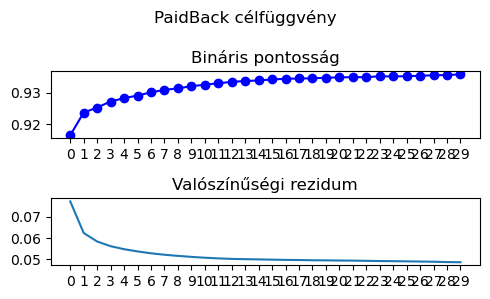

Normalizált adatok


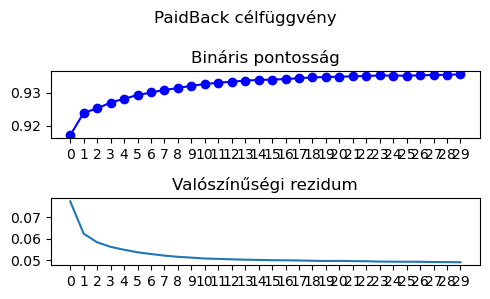

In [30]:
accuracy_binary = lambda D: [accuracy_score(x['y_true'], x['y_pred'].round()) for x in D]
accuracy_mean = lambda D: [mean_squared_error(x['y_true'], x['y_pred']) for x in D]

def accplot(accdata, objective):
    fig = plt.figure(figsize=(5,3))
    ax2 = fig.add_subplot(2,1,2)
    ax1 = fig.add_subplot(2,1,1, sharex=ax2) 
    fig.suptitle(objective + ' célfüggvény')
    ax1.plot(accuracy_binary(accdata), '-ob')
    ax1.set_title('Bináris pontosság')
    ax2.plot(accuracy_mean(accdata))
    ax2.set_title('Valószínűségi rezidum')
    plt.xticks(np.arange(0,len(accdata)))
    plt.tight_layout()
    plt.show()

print('Skálázatlan adatok')
accplot(A_e, 'PaidBack')
print('Standardizált adatok')
accplot(A_s, 'PaidBack')
print('Normalizált adatok')
accplot(A_n, 'PaidBack')

In [31]:
y_pred_binary_s = (A_s[-1]['y_pred']>= 0.5).astype(int)
y_pred_binary_n = (A_n[-1]['y_pred']>= 0.5).astype(int)
y_pred_binary_e = (A_e[-1]['y_pred']>= 0.5).astype(int)

accuracy_s_gt = accuracy_score(y_test_s, y_pred_binary_s)
accuracy_n_gt = accuracy_score(y_test_n, y_pred_binary_n)
accuracy_e_gt = accuracy_score(y_test_e, y_pred_binary_e)

precision_s_gt = precision_score(y_test_s, y_pred_binary_s, average='weighted')
precision_n_gt = precision_score(y_test_n,  y_pred_binary_n, average='weighted')
precision_e_gt = precision_score(y_test_e, y_pred_binary_e, average='weighted')

recall_s_gt = recall_score(y_test_s, y_pred_binary_s, average='weighted')
recall_n_gt = recall_score(y_test_n,  y_pred_binary_n, average='weighted')
recall_e_gt = recall_score(y_test_e, y_pred_binary_e, average='weighted')

f1_s_gt = f1_score(y_test_s, y_pred_binary_s, average='weighted')
f1_n_gt = f1_score(y_test_n, y_pred_binary_n, average='weighted')
f1_e_gt = f1_score(y_test_e, y_pred_binary_e, average='weighted')

mse_s_gt = mean_squared_error(y_test_s, y_pred_binary_s)
mse_n_gt = mean_squared_error(y_test_n, y_pred_binary_n)
mse_e_gt = mean_squared_error(y_test_e, y_pred_binary_e)

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_gt, precision_e_gt, recall_e_gt, f1_e_gt, mse_e_gt],
    "Standardizált adatok": [accuracy_s_gt, precision_s_gt, recall_s_gt, f1_s_gt, mse_s_gt],
    "Normalizált adatok": [accuracy_n_gt, precision_n_gt, recall_n_gt, f1_n_gt, mse_n_gt]   
}

results_df = pd.DataFrame(results)
print(results_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.935322              0.935822            0.935539
1  Precision            0.935015              0.935536            0.935231
2     Recall            0.935322              0.935822            0.935539
3   F1 Score            0.935154              0.935666            0.935370
4        MSE            0.064678              0.064178            0.064461


In [32]:
y_predfinal_s = pd.DataFrame({'pred': A_s[-1]['y_pred'].copy().round()})
cm_s_gt = confusion_matrix(y_test_s, y_predfinal_s)

y_predfinal_n = pd.DataFrame({'pred': A_n[-1]['y_pred'].copy().round()})
cm_n_gt = confusion_matrix(y_test_n, y_predfinal_n)

y_predfinal_e = pd.DataFrame({'pred': A_e[-1]['y_pred'].copy().round()})
cm_e_gt = confusion_matrix(y_test_e, y_predfinal_e)

print('Skálázatlan adatok')
print(classification_report(y_test_e, y_predfinal_n))
print("Standardizált adatok")
print(classification_report(y_test_s, y_predfinal_s))
print('Normalizált adatok')
print(classification_report(y_test_n, y_predfinal_n))

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     24677
           1       0.96      0.96      0.96     81449

    accuracy                           0.94    106126
   macro avg       0.91      0.91      0.91    106126
weighted avg       0.94      0.94      0.94    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     24677
           1       0.96      0.96      0.96     81449

    accuracy                           0.94    106126
   macro avg       0.91      0.91      0.91    106126
weighted avg       0.94      0.94      0.94    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     24677
           1       0.96      0.96      0.96     81449

    accuracy                           0.94    106126
   macro avg       0.91      0.91      0.91    106126
weighted avg   

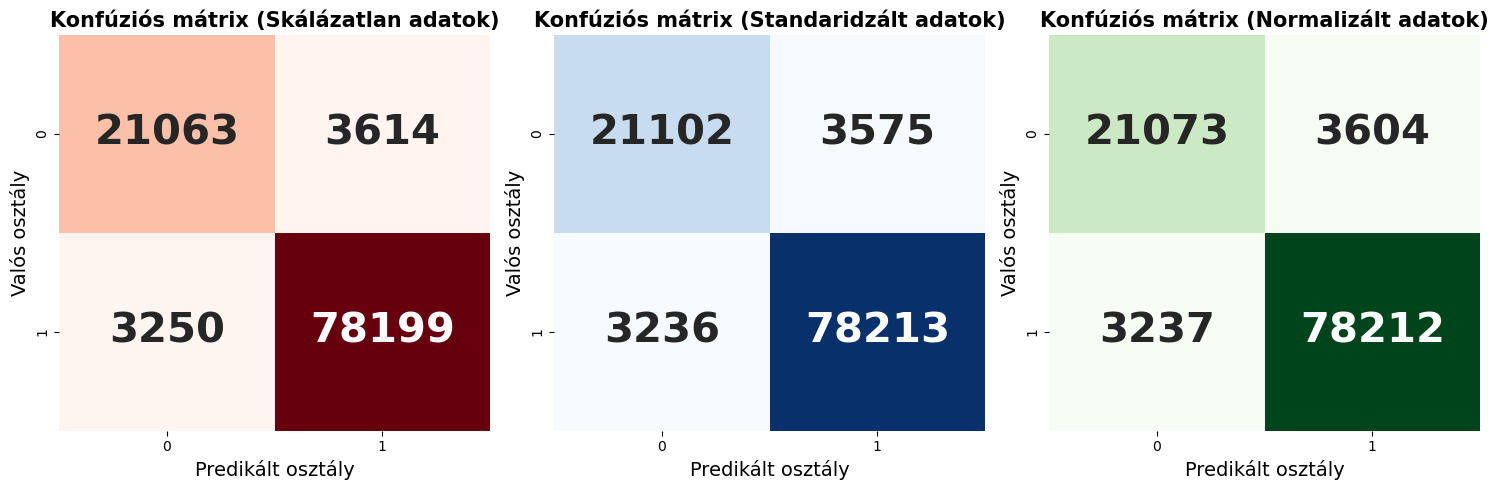

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_gt, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_gt, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standaridzált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_gt, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## SVM modell

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train_s, y_train_s)

print(grid.best_params_)
print(grid.best_estimator_)

y_pred_s = grid.predict(X_test_s)
accuracy = accuracy_score(y_test_s, y_pred_s)
print("Accuracy (Standardized data)", accuracy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=0.841 total time=874.8min


## Neurális háló Keras

3317/3317 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 3s 996us/step
A tanítási idő: 2386.59 másodperc
Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24677
           1       0.77      1.00      0.87     81449

    accuracy                           0.77    106126
   macro avg       0.38      0.50      0.43    106126
weighted avg       0.59      0.77      0.67    106126

Standardizált adatok
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     24677
           1       0.93      0.94      0.94     81449

    accuracy                           0.90    106126
   macro avg       0.87      0.86      0.86    106126
weighted avg       0.90      0.90      0.90    106126

Normalizált adatok
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     24677
           1 

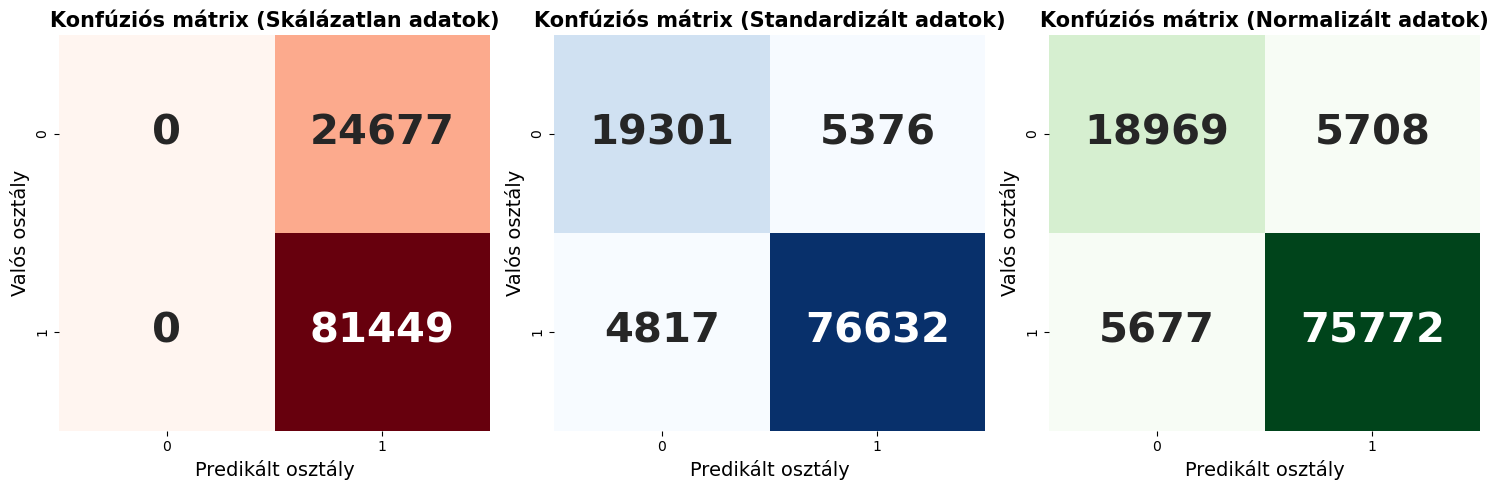

In [39]:
def check_and_convert_data(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    return data.astype(np.float32)

def create_and_train_model(X_train, y_train, X_test, y_test):
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=50, batch_size=32, verbose=0)
    
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    return model, y_pred

X_train_s = check_and_convert_data(X_train_s)
X_test_s = check_and_convert_data(X_test_s)
X_train_n = check_and_convert_data(X_train_n)
X_test_n = check_and_convert_data(X_test_n)
X_train_e = check_and_convert_data(X_train_e)
X_test_e = check_and_convert_data(X_test_e)
y_train_s = np.array(y_train_s)
y_test_s = np.array(y_test_s)
y_train_n = np.array(y_train_n)
y_test_n = np.array(y_test_n)
y_train_e = np.array(y_train_e)
y_test_e = np.array(y_test_e)

start_time = time.time()

model_s, y_pred_s_nn = create_and_train_model(X_train_s, y_train_s, X_test_s, y_test_s)
model_n, y_pred_n_nn = create_and_train_model(X_train_n, y_train_n, X_test_n, y_test_n)
model_e, y_pred_e_nn = create_and_train_model(X_train_e, y_train_e, X_test_e, y_test_e)

end_time = time.time()
training_time = end_time - start_time
print(f"A tanítási idő: {training_time:.2f} másodperc")

accuracy_s_nn = accuracy_score(y_test_s, y_pred_s_nn)
accuracy_n_nn = accuracy_score(y_test_n, y_pred_n_nn)
accuracy_e_nn = accuracy_score(y_test_e, y_pred_e_nn)

precision_s_nn = precision_score(y_test_s, y_pred_s_nn, average='weighted')
precision_n_nn = precision_score(y_test_n, y_pred_n_nn, average='weighted')
precision_e_nn = precision_score(y_test_e, y_pred_e_nn, average='weighted')

recall_s_nn = recall_score(y_test_s, y_pred_s_nn, average='weighted')
recall_n_nn = recall_score(y_test_n, y_pred_n_nn, average='weighted')
recall_e_nn = recall_score(y_test_e, y_pred_e_nn, average='weighted')

f1_s_nn = f1_score(y_test_s, y_pred_s_nn, average='weighted')
f1_n_nn = f1_score(y_test_n, y_pred_n_nn, average='weighted')
f1_e_nn = f1_score(y_test_e, y_pred_e_nn, average='weighted')

mse_s_nn = mean_squared_error(y_test_s, y_pred_s_nn)
mse_n_nn = mean_squared_error(y_test_n, y_pred_n_nn)
mse_e_nn = mean_squared_error(y_test_e, y_pred_e_nn)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e_nn))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s_nn))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n_nn))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE"],
    "Skálázatlan adatok": [accuracy_e_nn, precision_e_nn, recall_e_nn, f1_e_nn, mse_e_nn],
    "Standardizált adatok": [accuracy_s_nn, precision_s_nn, recall_s_nn, f1_s_nn, mse_s_nn],
    "Normalizált adatok": [accuracy_n_nn, precision_n_nn, recall_n_nn, f1_n_nn, mse_n_nn]   
}

results_df = pd.DataFrame(results)
print(results_df)

cm_s_nn = confusion_matrix(y_test_s, y_pred_s_nn)
cm_n_nn = confusion_matrix(y_test_n, y_pred_n_nn)
cm_e_nn = confusion_matrix(y_test_e, y_pred_e_nn)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_nn, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_nn, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_nn, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.tight_layout()
plt.show()